In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
from IPython.display import display as disp
import stringcase

import numpy as np
import numpy.ma as ma
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]


# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, plotting, modeleval

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn import model_selection
from sklearn.pipeline import Pipeline

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='../joblib_cache', verbose=0)

%matplotlib inline

sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=2.8)
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = np.array([12, 7]) * 0.75
mpl.rcParams['text.usetex'] = True  

In [2]:
mpl.rcParams['figure.figsize'] = np.array([12, 7]) * 0.75 

# The data

`x` indicates activity, partitioned into eight quarters, for the four channels ABCD.
`y` indicates movement.

In [3]:
data_path = '../../allan_data/DataPredictMovement_half.p'

In [4]:
x, y = np.load(data_path) 

In [19]:
xx = x.copy()
xx[xx==-1] = 0

yy = y.copy() 
yy[yy==-1] = 0

In [20]:
columns=[f"{com}{qrt}" for com in "call sms gps bt".split() for qrt in range(1, 9)] 
dfx = pd.DataFrame(x, columns=columns) 

In [21]:
dfx.head() 

,call1,call2,call3,call4,call5,call6,call7,call8,sms1,sms2,...,gps7,gps8,bt1,bt2,bt3,bt4,bt5,bt6,bt7,bt8
0,-1,-1,-1,1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,1,-1,-1,-1,-1,1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1


In [22]:
x.shape

(6549096, 32)

In [23]:
np.arange(2, x.shape[1]+1, 3) 

array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32])

Plotting the average value of the `x`-vectors, we see that every first quarter of an lower amound of activity. This could reflect human behaviour, because events often start on an hourly basis, or it could be a binning problem.

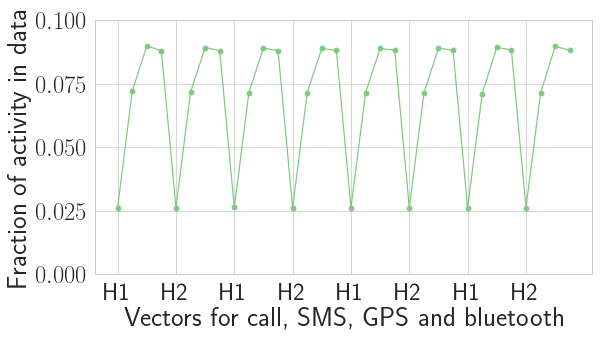

In [24]:
fig, ax = plt.subplots()
ax.plot(xx.mean(axis=0), 'o-', c=colorcycle[0])
# xticks = np.array([np.array([0, 3]) + (i*4) for i in range(0, 8)]).ravel() 
xticks = np.arange(0, 32, 4)
ax.set_xticks(xticks) 
ax.set_yticks(np.linspace(0, 0.1, 5))
ax.set_xticklabels(["H1", "H2"]*4);
ax.set_xlabel("Vectors for call, SMS, GPS and bluetooth")
ax.set_ylabel("Fraction of activity in data")
plt.tight_layout() 
# fig.subplots_adjust(bottom=0.15) 
fig.savefig('figs/quarters_value.pdf') 

Below is the average of the four quarters in an hour. The same effect with low counts in the first quarter is seen.

In [8]:
means = np.zeros(4)
base_idx = np.arange(0, 32, 4)
for i in range(4):
    idx = base_idx + i
    icut = min(base_idx[-1]+i, xx.shape[1])
    idx = idx[idx <= icut]
    arr = xx[:, base_idx + i]
    means[i] = arr.mean()
    print("%.3f" % means[i])


0.026
0.071
0.089
0.088


In [9]:
np.savetxt('quarterly_averages_accross_all_channels.txt', means)

In [10]:
del xx, yy

Heatmap of the correlation shows the same pattern... perhaps a dimmensionality reduction is in order, since the intrinsic dimmension of the data might be quite a bit smaller than the current dimmensionalty.

In [11]:
sample_idx = np.random.choice(range(len(y)), len(y)//25) 
dfs = pd.DataFrame(x[sample_idx, :])
corr = dfs.corr() 

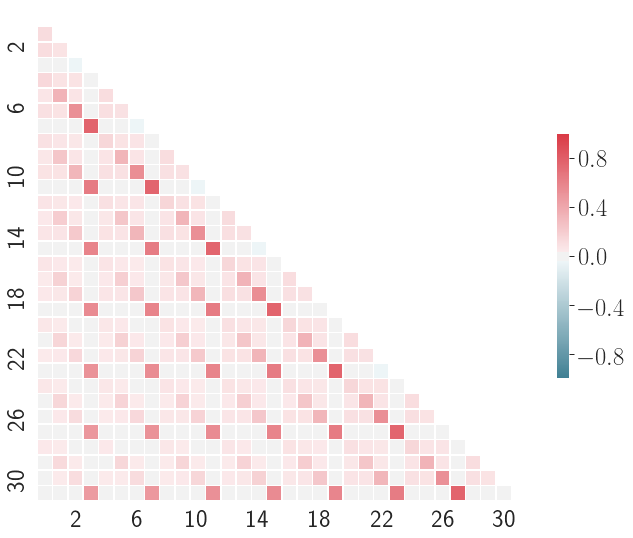

In [12]:
with sns.axes_style("white"):  # ticks
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    # ticks = [str(i) if (i % 2 == 1) else ' ' for i in range(32)]
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) 
    for lx, ly in zip(ax.get_xticklabels()[::2], ax.get_yticklabels()[::2]):
        lx.set_visible(False)
        ly.set_visible(False) 
    
    fig.savefig("figs/quarters_correlations.pdf") 

In [13]:
pca = PCA() 
pca.fit(x)
xx = pca.transform(x)

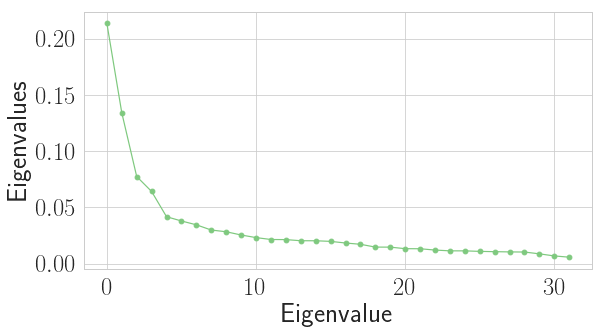

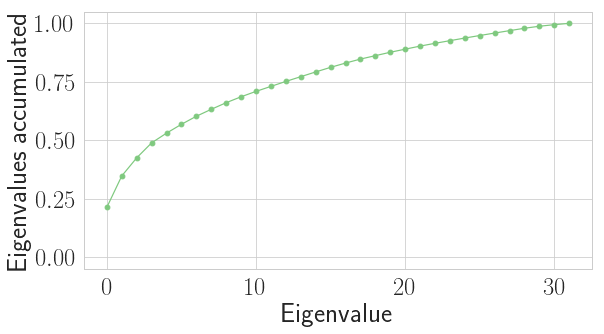

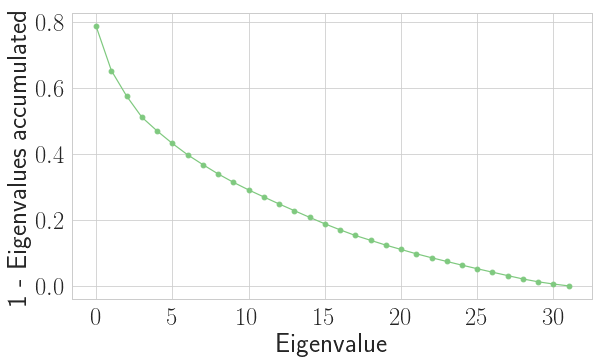

In [89]:
fig, ax = plt.subplots() 
ax.set_ybound(-0.05, 0.25)
ax.plot(pca.explained_variance_ratio_, 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues')
plt.tight_layout() 
# fig.subplots_adjust(left=0.15, bottom=0.15)
fig.savefig('figs/pca_eigenvalues_userMovement.pdf')

fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues accumulated')
ax.set_ylim(-0.05, 1.05)
plt.tight_layout() 
# fig.subplots_adjust(bottom=0.15)
fig.savefig('figs/pca_eigenvalues_accumulated_userMovement.pdf')

fig, ax = plt.subplots()
ax.plot(1 - np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('1 - Eigenvalues accumulated')
# ax.set_ylim(-0.05, 1.05)
plt.tight_layout() 
fig.subplots_adjust(bottom=0.15)
fig.savefig('figs/pca_eigenvalues_scree_userMovement.pdf') 

# Results of the cross validation

Plotting and listing results

In [9]:
with open('userMovement_sgd_std_final_coarse.pkl', 'br') as fid:
    est = pickle.load(fid) 

Convert to DataFrame, explore random sampled of relevant columns

In [10]:
cvr = pd.DataFrame(est.cv_results_)
cvr.filter(regex=r'^(?:param_|mean.+score$)').sample(20) 

,mean_test_score,mean_train_score,param_pca__n_components,param_sgd__alpha,param_sgd__class_weight,param_sgd__loss,param_sgd__penalty
1105,0.840844,0.840862,9,0.1,balanced,modified_huber,elasticnet
736,0.830408,0.830423,5,0.215443,balanced,hinge,l2
124,0.792245,0.792217,2,0.0215443,balanced,hinge,l2
1102,0.767028,0.766981,9,0.0464159,None,hinge,l2
1988,0.848031,0.848155,30,0.000464159,None,log,l2
222,0.782572,0.782579,3,4.64159e-05,None,modified_huber,l2
548,0.816418,0.816419,4,0.215443,None,log,l2
1911,0.816904,0.817019,27,1,balanced,log,elasticnet
772,0.817004,0.817074,6,1e-05,balanced,hinge,l2
1773,0.845288,0.845489,27,0.0001,None,log,elasticnet


In [12]:
est.best_params_

{'pca__n_components': 27,
 'sgd__alpha': 1.0,
 'sgd__class_weight': 'balanced',
 'sgd__loss': 'log',
 'sgd__penalty': 'l2'}

In [13]:
est.best_score_

0.8510681121381051

In [14]:
est.validation_auc_score

0.851849571922662

In [15]:
est.param_grid

{'pca__n_components': array([ 2,  3,  4,  5,  6,  9, 12, 16, 23, 27, 30, 31, 32]),
 'sgd__alpha': array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04, 2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
        4.64158883e-03, 1.00000000e-02, 2.15443469e-02, 4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01, 1.00000000e+00]),
 'sgd__class_weight': ['balanced', None],
 'sgd__loss': ['modified_huber', 'log', 'hinge'],
 'sgd__penalty': ['l2', 'elasticnet']}

Explore best parameters

In [161]:
expl = cvr.filter(regex=r'^(?:param_|mean.+score$)')[(cvr.param_sgd__alpha == 1) &
                                                     (cvr.param_pca__n_components == 27)]

expl

,mean_test_score,mean_train_score,param_pca__n_components,param_sgd__alpha,param_sgd__class_weight,param_sgd__loss,param_sgd__penalty
1908,0.850610,0.850639,27,1,balanced,modified_huber,l2
1909,0.842444,0.842453,27,1,balanced,modified_huber,elasticnet
1910,0.851068,0.851084,27,1,balanced,log,l2
1911,0.816904,0.817019,27,1,balanced,log,elasticnet
1912,0.835195,0.835180,27,1,balanced,hinge,l2
1913,0.838133,0.838116,27,1,balanced,hinge,elasticnet
1914,0.850488,0.850512,27,1,None,modified_huber,l2
1915,0.837119,0.837000,27,1,None,modified_huber,elasticnet
1916,0.850473,0.850504,27,1,None,log,l2
1917,0.500000,0.500000,27,1,None,log,elasticnet


In [162]:
expl.mean() 

mean_test_score             0.777365
mean_train_score            0.777379
param_pca__n_components    27.000000
param_sgd__alpha            1.000000
dtype: float64

In [163]:
est.param_grid

{'pca__n_components': array([ 2,  3,  4,  5,  6,  9, 12, 16, 23, 27, 30, 31, 32]),
 'sgd__alpha': array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04, 2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
        4.64158883e-03, 1.00000000e-02, 2.15443469e-02, 4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01, 1.00000000e+00]),
 'sgd__class_weight': ['balanced', None],
 'sgd__loss': ['modified_huber', 'log', 'hinge'],
 'sgd__penalty': ['l2', 'elasticnet']}

In [164]:
est.best_score_

0.8510681121381051

In [165]:
est.validation_auc_score

0.851849571922662

In [166]:
est.best_params_

{'pca__n_components': 27,
 'sgd__alpha': 1.0,
 'sgd__class_weight': 'balanced',
 'sgd__loss': 'log',
 'sgd__penalty': 'l2'}

In [167]:
bestmodel = cvr[(cvr.param_sgd__penalty == 'l2') & 
                (cvr.param_sgd__class_weight == 'balanced') & 
                (cvr.param_sgd__loss == 'log')]

In [168]:
bestscores = bestmodel[['mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)[:10]

In [169]:
for _, (avg, std) in bestscores.iterrows():
    # print(f"{avg:.6f} ± {std:.2e}")
    # LaTeX format
    front, back = (f"{std:.2e}").split('e') 
    print(f"{avg:.6f} \\pm {front} \\cdot 10^{{{back.replace('0', '')}}}")  # LaTeX version

0.851068 \pm 8.09 \cdot 10^{-4}
0.851062 \pm 8.33 \cdot 10^{-4}
0.851017 \pm 8.01 \cdot 10^{-4}
0.851014 \pm 8.12 \cdot 10^{-4}
0.851003 \pm 7.86 \cdot 10^{-4}
0.851001 \pm 7.93 \cdot 10^{-4}
0.850991 \pm 7.94 \cdot 10^{-4}
0.850988 \pm 8.35 \cdot 10^{-4}
0.850976 \pm 7.89 \cdot 10^{-4}
0.850967 \pm 8.23 \cdot 10^{-4}


# Construct new grid

In [135]:
{'pca__n_components': np.array([2, 3, 4, 5, 6, 9, 12, 16, 23, 27, 30, 31, 32]),
 'sgd__alpha': 10**np.linspace(-5, 0, 16),
 'sgd__class_weight': ['balanced', None],
 'sgd__loss': ['modified_huber', 'log', 'hinge'],
 'sgd__penalty': ['l2', 'elasticnet']} 

{'pca__n_components': array([ 2,  3,  4,  5,  6,  7,  9, 12, 15, 18, 21, 24, 27, 28, 29, 30, 31, 32]),
 'sgd__alpha': array([1.00000000e-05, 1.96841945e-05, 3.87467512e-05, 7.62698586e-05, 1.50131073e-04, 2.95520924e-04, 5.81709133e-04, 1.14504757e-03,
        2.25393390e-03, 4.43668733e-03, 8.73326162e-03, 1.71907220e-02, 3.38385515e-02, 6.66084629e-02, 1.31113394e-01, 2.58086154e-01,
        5.08021805e-01, 1.00000000e+00]),
 'sgd__class_weight': ['balanced', None],
 'sgd__loss': ['modified_huber', 'log', 'hinge'],
 'sgd__penalty': ['l2', 'elasticnet']}

# Examine RF grid

In [5]:
with open('userMovement_rf_coarse.pkl', 'br') as fid:
    rf = pickle.load(fid)  

In [6]:
cvrf = pd.DataFrame(rf.cv_results_)
rfgbu = cvrf.groupby([cvrf.param_rf__n_estimators, cvrf.param_rf__max_depth]).mean_test_score.mean().unstack() 
rfgbus = cvrf.groupby([cvrf.param_rf__n_estimators, cvrf.param_rf__max_depth]).std_test_score.mean().unstack() 

In [7]:
desc = cvrf[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_test_score']].describe() 
desc

,mean_test_score,std_test_score,mean_train_score,std_test_score
count,264.000000,264.000000,264.000000,264.000000
mean,0.842411,0.000887,0.866912,0.000887
std,0.017594,0.001576,0.012098,0.001576
min,0.785924,0.000072,0.832550,0.000072
25%,0.833760,0.000510,0.856556,0.000510
50%,0.850580,0.000687,0.863766,0.000687
75%,0.854719,0.000871,0.878939,0.000871
max,0.858456,0.024757,0.887921,0.024757


In [8]:
print(desc.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  mean\_test\_score &  std\_test\_score &  mean\_train\_score &  std\_test\_score \\
\midrule
count &       264.000000 &      264.000000 &        264.000000 &      264.000000 \\
mean  &         0.842411 &        0.000887 &          0.866912 &        0.000887 \\
std   &         0.017594 &        0.001576 &          0.012098 &        0.001576 \\
min   &         0.785924 &        0.000072 &          0.832550 &        0.000072 \\
25\%   &         0.833760 &        0.000510 &          0.856556 &        0.000510 \\
50\%   &         0.850580 &        0.000687 &          0.863766 &        0.000687 \\
75\%   &         0.854719 &        0.000871 &          0.878939 &        0.000871 \\
max   &         0.858456 &        0.024757 &          0.887921 &        0.024757 \\
\bottomrule
\end{tabular}



In [9]:
rfgbu.index.name = '\\# estimators'
rfgbu.columns.name = 'Max depth'
rfgbus.index.name = '\\# estimators'
rfgbus.columns.name = 'Max depth'

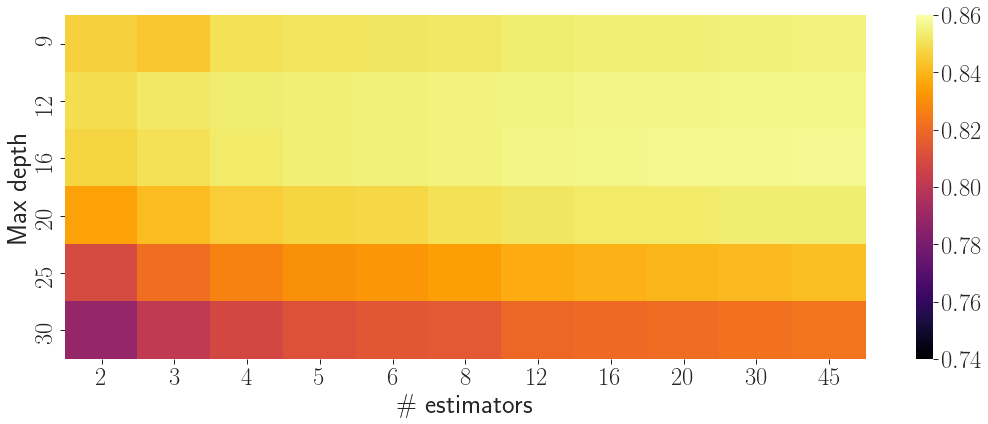

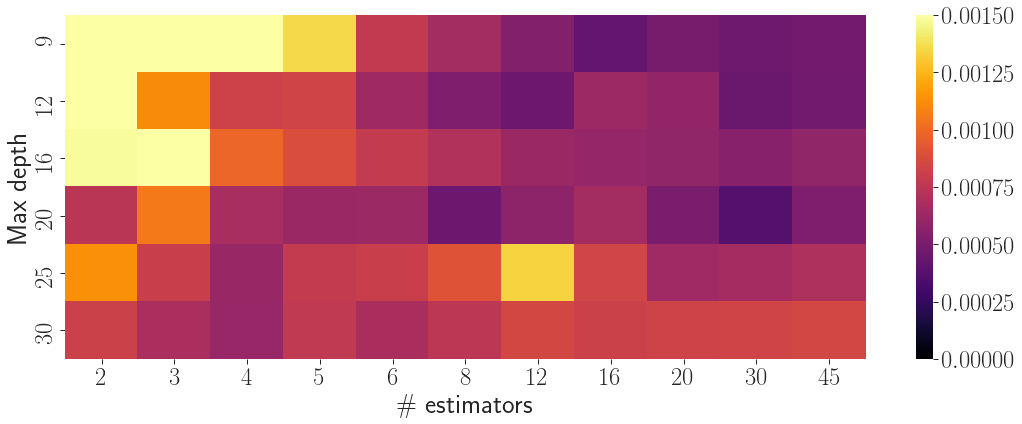

In [162]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=[15, 6]) 
    sns.heatmap(rfgbu.T, cmap='inferno', vmin=0.74, vmax=0.86, ax=ax) 
    xticklabels = ['$' + el.get_text() + '$' for el in ax.get_xticklabels()]
    yticklabels = ['$' + el.get_text() + '$' for el in ax.get_yticklabels()]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    plt.tight_layout() 
    fig.savefig('figs/random_forest_coarse_gridsearch_auc_test_mean.pdf')

    fig, ax = plt.subplots(figsize=[15, 6]) 
    sns.heatmap(rfgbus.T, cmap='inferno', vmin=0.0, vmax=0.0015, ax=ax) 
    xticklabels = ['$' + el.get_text() + '$' for el in ax.get_xticklabels()]
    yticklabels = ['$' + el.get_text() + '$' for el in ax.get_yticklabels()] 
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    plt.tight_layout()
    fig.savefig('figs/random_forest_coarse_gridsearch_auc_test_std.pdf')

In [10]:
rf.best_params_

{'rf__class_weight': None,
 'rf__criterion': 'entropy',
 'rf__max_depth': 16,
 'rf__n_estimators': 45}

In [11]:
rf.best_score_

0.8584558041362306

In [12]:
rf.validation_auc_score

0.8589634875117511

# Examine RF grid, fine search

In [13]:
with open('userMovement_rf_finer.pkl', 'br') as fid:
    rf = pickle.load(fid) 

In [164]:
cvrf = pd.DataFrame(rf.cv_results_)
rfgbu = cvrf.groupby([cvrf.param_rf__n_estimators, cvrf.param_rf__max_depth]).mean_test_score.mean().unstack() 
rfgbus = cvrf.groupby([cvrf.param_rf__n_estimators, cvrf.param_rf__max_depth]).std_test_score.mean().unstack() 

In [165]:
desc = cvrf[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_test_score']].describe() 
desc 

,mean_test_score,std_test_score,mean_train_score,std_test_score
count,399.000000,399.000000,399.000000,399.000000
mean,0.858678,0.000348,0.864280,0.000348
std,0.000164,0.000028,0.002636,0.000028
min,0.858208,0.000262,0.860357,0.000262
25%,0.858567,0.000334,0.861724,0.000334
50%,0.858713,0.000349,0.864082,0.000349
75%,0.858816,0.000363,0.866887,0.000363
max,0.858910,0.000531,0.868535,0.000531


In [166]:
print(desc.to_latex()) 

\begin{tabular}{lrrrr}
\toprule
{} &  mean\_test\_score &  std\_test\_score &  mean\_train\_score &  std\_test\_score \\
\midrule
count &       399.000000 &      399.000000 &        399.000000 &      399.000000 \\
mean  &         0.858678 &        0.000348 &          0.864280 &        0.000348 \\
std   &         0.000164 &        0.000028 &          0.002636 &        0.000028 \\
min   &         0.858208 &        0.000262 &          0.860357 &        0.000262 \\
25\%   &         0.858567 &        0.000334 &          0.861724 &        0.000334 \\
50\%   &         0.858713 &        0.000349 &          0.864082 &        0.000349 \\
75\%   &         0.858816 &        0.000363 &          0.866887 &        0.000363 \\
max   &         0.858910 &        0.000531 &          0.868535 &        0.000531 \\
\bottomrule
\end{tabular}



In [167]:
rfgbu.index.name = '\\# estimators'
rfgbu.columns.name = 'Max depth'
rfgbus.index.name = '\\# estimators'
rfgbus.columns.name = 'Max depth'

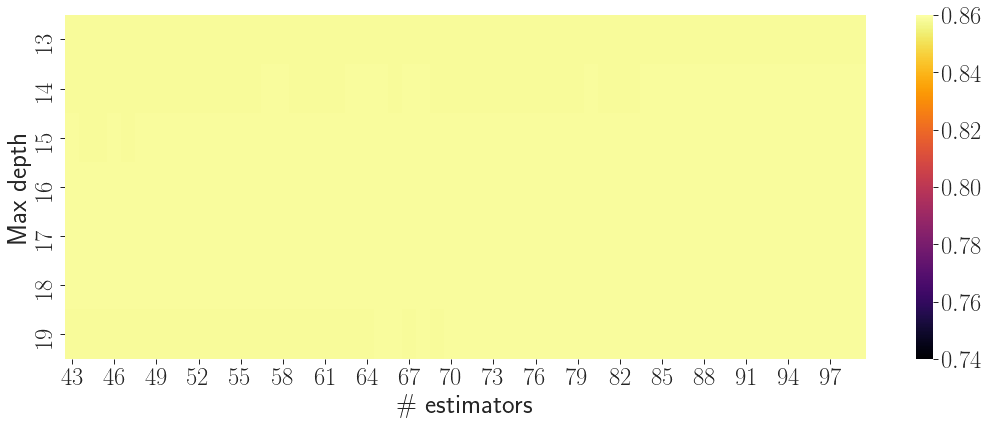

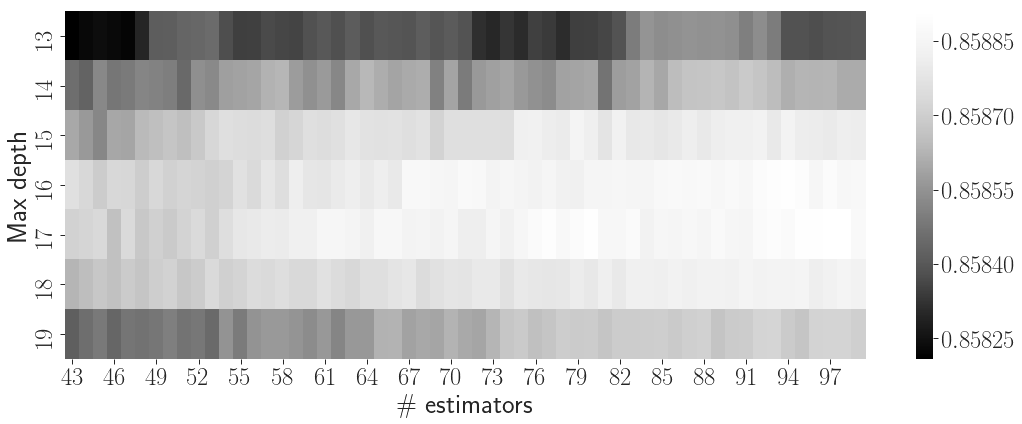

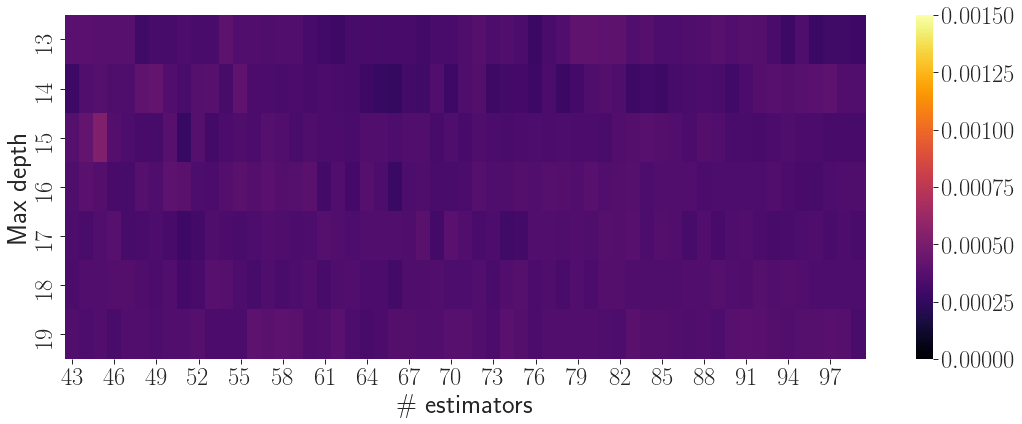

In [168]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=[15, 6]) 
    sns.heatmap(rfgbu.T, cmap='inferno', vmin=0.74, vmax=0.86, ax=ax) 
    xticklabels = ['$' + el.get_text() + '$' for el in ax.get_xticklabels()]
    yticklabels = ['$' + el.get_text() + '$' for el in ax.get_yticklabels()]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels) 
    plt.tight_layout()
    fig.savefig('figs/random_forest_fine_gridsearch_auc_test_mean.pdf')

    fig, ax = plt.subplots(figsize=[15, 6]) 
    sns.heatmap(rfgbu.T, cmap='Greys_r', ax=ax) 
    xticklabels = ['$' + el.get_text() + '$' for el in ax.get_xticklabels()]
    yticklabels = ['$' + el.get_text() + '$' for el in ax.get_yticklabels()]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    plt.tight_layout()
    fig.savefig('figs/random_forest_fine_gridsearch_auc_test_mean_nolimits.pdf')

    fig, ax = plt.subplots(figsize=[15, 6]) 
    sns.heatmap(rfgbus.T, cmap='inferno', vmin=0.0, vmax=0.0015, ax=ax) 
    xticklabels = ['$' + el.get_text() + '$' for el in ax.get_xticklabels()]
    yticklabels = ['$' + el.get_text() + '$' for el in ax.get_yticklabels()] 
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    plt.tight_layout()
    fig.savefig('figs/random_forest_fine_gridsearch_auc_test_std.pdf')

In [169]:
rfgbu.values.min(), rfgbu.values.max()

(0.8582084580453364, 0.8589099565292093)

In [143]:
rf.best_params_

{'rf__max_depth': 17, 'rf__n_estimators': 97}

In [144]:
rf.param_grid

{'rf__max_depth': array([13, 14, 15, 16, 17, 18, 19]),
 'rf__n_estimators': array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
        77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}

In [145]:
rf.best_score_

0.8589099565292093

In [14]:
rf.validation_auc_score

0.8582778421410656

# Examine CV result further

In [11]:
sidx = cvr.mean_test_score.argsort()[::-1]

mtes = cvr.mean_test_score[sidx]

stes = cvr.std_test_score[sidx]

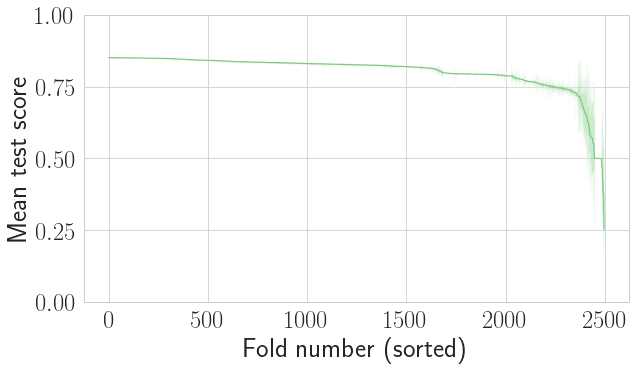

In [12]:
fig, ax = plt.subplots()
plotx = np.arange(len(mtes))
every_n = 20
ax.plot(plotx, mtes)
# ax.errorbar(plotx[::every_n], mtes[::every_n], stes[::every_n], color=colorcycle[0])
ax.fill_between(plotx, mtes+stes, mtes-stes, alpha=0.4)
ax.set_xlabel("Fold number (sorted)")
ax.set_ylabel(r"Mean test score")
ax.set_yticks(np.linspace(0, 1, 5))
plt.tight_layout() 
fig.savefig("figs/usermovement_cv_mean_test_score.pdf") 

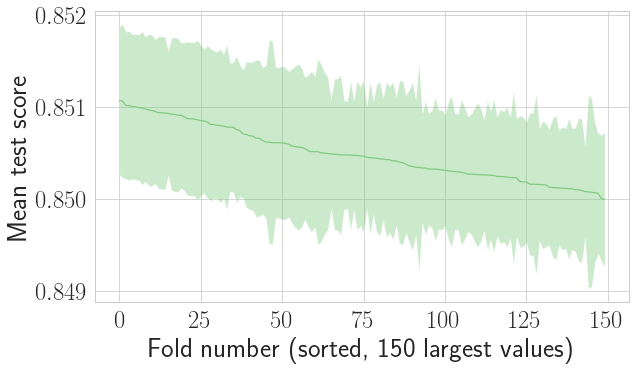

In [13]:
fig, ax = plt.subplots()
plotx = np.arange(len(mtes))
crop_n = 150
every_n = 5
ax.plot(plotx[:crop_n], mtes[:crop_n])
# ax.errorbar(plotx[:crop_n][::every_n], mtes[:crop_n][::every_n], stes[:crop_n][::every_n], color=colorcycle[0])
ax.fill_between(plotx[:crop_n], mtes[:crop_n]+stes[:crop_n], mtes[:crop_n]-stes[:crop_n], alpha=0.4)
ax.set_xlabel(f"Fold number (sorted, {crop_n} largest values)")
ax.set_ylabel(r"Mean test score")
plt.tight_layout() 
fig.savefig("figs/usermovement_cv_mean_test_score_crop.pdf") 

In [14]:
tmp = cvr.param_sgd__loss[sidx].reset_index(drop=True)

In [15]:
(tmp != 'log').argmax() 

45

The best 45 performers are logistic regressions

In [16]:
tmp = cvr[['param_sgd__loss', 'mean_test_score']].iloc[sidx[:2000]].reset_index(drop=True) 

tmp.groupby('param_sgd__loss').mean_test_score.agg(['sum', 'mean', 'median']) 

,sum,mean,median
param_sgd__loss,,,
hinge,343.056406,0.822677,0.827204
log,666.682124,0.831274,0.834956
modified_huber,645.592172,0.826622,0.827922


In [17]:
to_report = cvr.groupby('param_sgd__loss').mean_test_score.agg(['sum', 'mean', 'median', 'std']) 
disp(to_report)
print(to_report.to_latex()) 

,sum,mean,median,std
param_sgd__loss,,,,
hinge,636.512151,0.765039,0.788965,0.088548
log,686.403674,0.825004,0.834271,0.045438
modified_huber,685.057552,0.823386,0.826408,0.022660


\begin{tabular}{lrrrr}
\toprule
{} &         sum &      mean &    median &       std \\
param\_sgd\_\_loss &             &           &           &           \\
\midrule
hinge           &  636.512151 &  0.765039 &  0.788965 &  0.088548 \\
log             &  686.403674 &  0.825004 &  0.834271 &  0.045438 \\
modified\_huber  &  685.057552 &  0.823386 &  0.826408 &  0.022660 \\
\bottomrule
\end{tabular}



In [18]:
tmp = cvr[['param_sgd__loss', 'mean_test_score']].iloc[sidx[:150]].reset_index(drop=True) 

to_report = tmp.groupby('param_sgd__loss').mean_test_score.agg(['sum', 'mean', 'median', 'std']) 
disp(to_report)
print(to_report.to_latex()) 

,sum,mean,median,std
param_sgd__loss,,,,
log,75.705055,0.850619,0.850632,0.000284
modified_huber,51.868488,0.850303,0.850299,0.000169


\begin{tabular}{lrrrr}
\toprule
{} &        sum &      mean &    median &       std \\
param\_sgd\_\_loss &            &           &           &           \\
\midrule
log             &  75.705055 &  0.850619 &  0.850632 &  0.000284 \\
modified\_huber  &  51.868488 &  0.850303 &  0.850299 &  0.000169 \\
\bottomrule
\end{tabular}



In [19]:
tmp = cvr[['param_sgd__loss', 'mean_test_score']]
tmp = tmp.rename(columns={'param_sgd__loss': 'Loss function', 'mean_test_score': 'Mean AUC test score'})
tmp['Loss function'] = tmp['Loss function'].str.replace('_', ' ')
tmp['Loss function'] = tmp['Loss function'].str.title() 
tmp['Loss function'] = tmp['Loss function'].str.replace('Log', 'Logistic Reg.') 

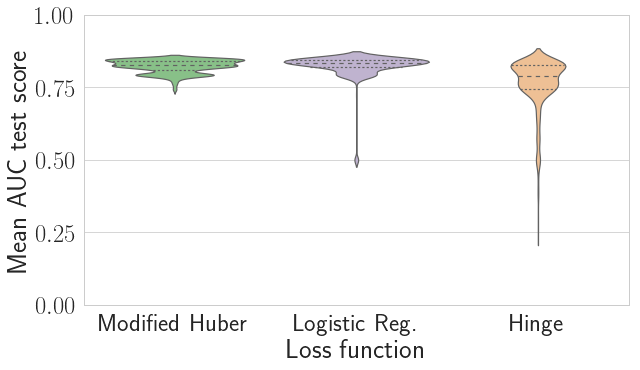

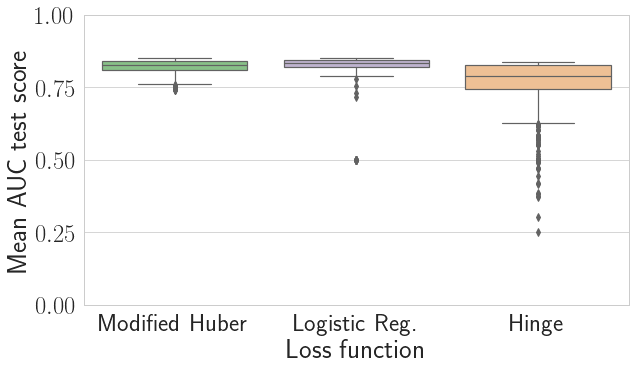

In [20]:
fig, ax = plt.subplots()
sns.violinplot(data=tmp, x='Loss function', y='Mean AUC test score', inner='quartile')
ax.set_yticks(np.linspace(0, 1, 5))
plt.tight_layout() 
fig.savefig('figs/sgd_coarse_cv_result_all_values_violinplot.pdf')

fig, ax = plt.subplots()
sns.boxplot(data=tmp, x='Loss function', y='Mean AUC test score') 
ax.set_yticks(np.linspace(0, 1, 5)) 
plt.tight_layout()  
fig.savefig('figs/sgd_coarse_cv_result_all_values_boxplot.pdf')

TypeError: fill_between() missing 2 required positional arguments: 'x' and 'y1'

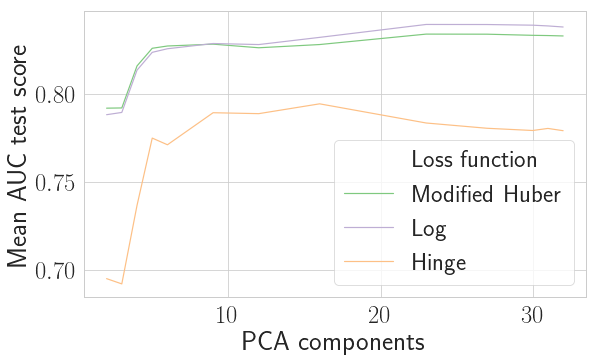

In [25]:
cvr2 = cvr.rename(columns=misc.snake2word(cvr.columns), index=misc.snake2word(cvr.index)) 
cvr2['param sgd loss'] = cvr2['param sgd loss'].str.replace('_', ' ').str.title() 
cvr2 = cvr2.rename(columns={'param sgd loss': 'Loss function'})

fig, ax = plt.subplots()
# sns.lineplot(data=cvr2, x='param pca n components', y='mean test score', hue='Loss function', ci=None)

ax.set_xlabel("PCA components")
ax.set_ylabel("Mean AUC test score")
for i in range(3):
    ax.fill_between()

In [253]:
cvr.groupby('param_pca__n_components')[['mean_test_score', 'std_test_score']].agg(
    {'_mean': 'mean',
     '_std': np.linalg.norm}) 

_mean                           _std               
                        mean_test_score std_test_score mean_test_score std_test_score
param_pca__n_components                                                              
2                              0.758421       0.020070       10.589746       0.807158
3                              0.757893       0.022753       10.571943       0.795051
4                              0.788755       0.013527       10.979399       0.515451
5                              0.808232       0.011043       11.223731       0.440996
6                              0.808079       0.010204       11.224140       0.384570
9                              0.815492       0.004032       11.316130       0.160375
12                             0.814435       0.004577       11.302891       0.156555
16                             0.818269       0.004328       11.354973       0.194554
23                             0.819062       0.005265       11.372621       0.184275
27                             0.818033       0.004634       11.361015       0.133509
30                             0.817274       0.004799       11.350685       0.149826
31                             0.817479       0.005321       11.352807       0.159094
32                             0.816771       0.005110       11.343690       0.160690

In [240]:
cvr.groupby('param_pca__n_components').mean_test_score.agg(['mean', 'median', 'std', lambda x: x.mean()])

,mean,median,std,<lambda>
param_pca__n_components,,,,
2,0.758421,0.792700,0.094448,0.758421
3,0.757893,0.793695,0.088052,0.757893
4,0.788755,0.817604,0.075804,0.788755
5,0.808232,0.826604,0.053668,0.808232
6,0.808079,0.827134,0.056368,0.808079
9,0.815492,0.827754,0.043996,0.815492
12,0.814435,0.828311,0.045821,0.814435
16,0.818269,0.832193,0.044552,0.818269
23,0.819062,0.839141,0.052726,0.819062


Just like the table of mean scores, make the matrix with standard deviations

# Combining the data differently

* I can simply group by quarter, and take the average, which still retains a lot of the information.
* I can use Median to maintain the binary nature of the data... how is ties resolved?
* I can remove the 0
* I can impute them using... median? MCMC?
* I can combine quarters on an hourly basis
* I can combine pr. channel, in the same way I combined on quarters, but this throws away some temporal information!

## Other ideas

Do HDB-scan and t-sne on data

In [42]:
df = pd.DataFrame(x, columns=[f"{c}{q}" for c in 'csgb' for q in range(1, 9)]) 
df.head() 

,c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,...,g7,g8,b1,b2,b3,b4,b5,b6,b7,b8
0,-1,-1,-1,1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,1,-1,-1,-1,-1,1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1


In [43]:
cmb = df.groupby(df.columns.str[-1], axis=1).mean()

In [44]:
cmb.head() 

,1,2,3,4,5,6,7,8
0,-1.0,-1.0,-0.5,-0.5,-1.0,-1.0,-0.5,-1.0
1,-1.0,-1.0,-1.0,0.5,-0.5,-1.0,-1.0,0.0
2,-1.0,-1.0,-0.5,-1.0,-1.0,-0.5,-0.5,-0.5
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.0,-1.0,-0.5,-1.0,-1.0,-1.0,-0.5,-1.0


In [45]:
cmb.to_msgpack('../../allan_data/DataPredictMovement_half_quarter_comb_mean.msgpack')

Combine hourly.

In [46]:
cmb_h = df.groupby(np.roll(df.columns.str[-1].astype(int) % 4, 1) + 1, axis=1).mean()

In [47]:
cmb_h.head() 

,1,2,3,4
0,-1.00,-1.00,-0.5,-0.75
1,-0.75,-1.00,-1.0,0.25
2,-1.00,-0.75,-0.5,-0.75
3,-1.00,-1.00,-1.0,-1.00
4,-0.50,-1.00,-0.5,-1.00


In [48]:
cmb_h.to_msgpack('../../allan_data/DataPredictMovement_half_quarter_comb_hourly_mean.msgpack')

# More cv analysis

In [49]:
print(*cvr.columns, sep='\n')

mean_fit_time
mean_score_time
mean_test_score
mean_train_score
param_pca__n_components
param_sgd__alpha
param_sgd__loss
param_sgd__penalty
params
rank_test_score
split0_test_score
split0_train_score
split1_test_score
split1_train_score
split2_test_score
split2_train_score
split3_test_score
split3_train_score
std_fit_time
std_score_time
std_test_score
std_train_score


In [50]:
mask_perceptron = (cvr.param_sgd__loss == 'perceptron') 

In [51]:
cvr.filter(regex=r'split.+score$').head() 

,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score
0,0.783605,0.783395,0.783299,0.782905,0.783763,0.783679,0.782906,0.783591
1,0.783835,0.783617,0.783640,0.783245,0.783842,0.783752,0.783119,0.783807
2,0.287112,0.286859,0.277437,0.277938,0.684258,0.682537,0.703380,0.704737
3,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
4,0.785722,0.785503,0.785953,0.785565,0.785829,0.785699,0.784981,0.785705


In [52]:
est.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

# Analysis of original data: State change

Make a dataset where a change of state is indicated, not the state itself.
Is this a better predictor?

Show columns, get a groupby to work

In [53]:
for k, v in dfx.columns.groupby(dfx.columns.str[:2]).items():
    print(*v, sep='\t')

bt1	bt2	bt3	bt4	bt5	bt6	bt7	bt8
call1	call2	call3	call4	call5	call6	call7	call8
gps1	gps2	gps3	gps4	gps5	gps6	gps7	gps8
sms1	sms2	sms3	sms4	sms5	sms6	sms7	sms8


In [54]:
dfxbt = dfx.filter(regex=r'bt')

In [55]:
(dfxbt.head().diff(axis=1).iloc[:, 1:] != 0).astype(int) 

,bt2,bt3,bt4,bt5,bt6,bt7,bt8
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,1
3,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0


In [56]:
dfch = (dfx.groupby(dfx.columns.str[:2], axis=1).diff(axis=1).iloc[:, 1:] != 0).astype(int) 

Onehot-like encoding

In [57]:
dfch.head() 

,call2,call3,call4,call5,call6,call7,call8,sms1,sms2,sms3,...,gps7,gps8,bt1,bt2,bt3,bt4,bt5,bt6,bt7,bt8
0,0,0,1,1,0,1,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,1,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,1,1,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,0,0,0,0


In [58]:
dfch.to_msgpack('../../allan_data/DataPredictMovement_change_of_movement_indicator_state.msgpack')

# Examine SGD fine search

In [25]:
!../../bin_allan/exa -l *pkl

.rw-rw-r--  21k bzg778 26 Jul  1:51 usermove_statechange.pkl
.rw-rw-r-- 356M bzg778 31 Jul 22:35 userMovement_cv_subgrid_search.pkl
.rw-rw-r-- 461M bzg778 31 Jul 22:09 userMovement_rf_coarse.pkl
.rw-rw-r-- 667M bzg778  1 Aug 14:54 userMovement_rf_finer.pkl
.rw-rw-r-- 356M bzg778 31 Jul 15:17 userMovement_sgd_std_final_coarse.pkl


In [27]:
with open('userMovement_cv_subgrid_search.pkl', 'br') as fid:
    est = pickle.load(fid)

In [29]:
est.best_score_

0.8509705960241408

In [30]:
est.validation_auc_score

0.8518750390426447

In [31]:
est.best_params_

{'pca__n_components': 28, 'sgd__alpha': 0.7196856730011519}